# PAOS

This notebook demonstrates the basic functionality of PAOS.

Select the desired example configuration desired below

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os, sys, time
from pathlib import Path
import importlib

# Add to PYTHONPATH the path to local libraries
paospath = "~/git/PAOS"
if not os.path.expanduser(paospath) in sys.path:
    sys.path.append( os.path.expanduser(paospath) )
    import paos
else:
    importlib.reload(paos)

## Inputs

Define lens file to use

In [2]:
OpticalPrescription = 'lens_file.ini'

OpticalPrescriptionFile = os.path.join(paospath, 'lens data', OpticalPrescription)

# Parse lens file
pup_diameter, parameters, wavelengths, fields, opt_chain = paos.ParseConfig(OpticalPrescriptionFile)

In [3]:
a=opt_chain[2]['ABCDt']
isinstance(a(), np.ndarray)

True

## Ray tracing
Implement a full raytracing. For diagnostic purposes.

In [4]:
raytracelist = paos.raytrace(fields[0], opt_chain)
for item in raytracelist:
    print(item)

paos - INFO - S02 - LOS tilt        y:  0.000mm ut: 1.745e-03 rad x:  0.000mm us:  0.000 rad
paos - INFO - S03 - Move to M1      y:500.000mm ut: 1.745e-03 rad x:  0.000mm us:  0.000 rad
paos - INFO - S04 - M1              y: 49.136mm ut: 4.294e-01 rad x:  0.000mm us:  0.000 rad
paos - INFO - S05 - M2              y: 24.559mm ut:-1.846e-02 rad x:  0.000mm us:  0.000 rad
paos - INFO - S06 - FOCUS           y: 19.855mm ut:-1.846e-02 rad x:  0.000mm us:  0.000 rad
paos - INFO - S07 - M3              y: 19.855mm ut: 9.637e-02 rad x:  0.000mm us:  0.000 rad
paos - INFO - S08 - Ray Centering   y: -0.018mm ut:-6.050e-05 rad x:  0.000mm us:  0.000 rad
paos - INFO - S09 - Move to M4      y: -0.006mm ut:-6.050e-05 rad x:  0.000mm us:  0.000 rad
paos - INFO - S10 - x tilt - M4     y: -0.009mm ut:-1.124e+00 rad x:  0.000mm us:  0.000 rad
paos - INFO - S11 - M4              y: -0.009mm ut: 1.124e+00 rad x:  0.000mm us:  0.000 rad
paos - INFO - S12 - x tilt - M4     y:  0.000mm ut: 6.050e-05 rad x:  

S02 - LOS tilt        y:  0.000mm ut: 1.745e-03 rad x:  0.000mm us:  0.000 rad
S03 - Move to M1      y:500.000mm ut: 1.745e-03 rad x:  0.000mm us:  0.000 rad
S04 - M1              y: 49.136mm ut: 4.294e-01 rad x:  0.000mm us:  0.000 rad
S05 - M2              y: 24.559mm ut:-1.846e-02 rad x:  0.000mm us:  0.000 rad
S06 - FOCUS           y: 19.855mm ut:-1.846e-02 rad x:  0.000mm us:  0.000 rad
S07 - M3              y: 19.855mm ut: 9.637e-02 rad x:  0.000mm us:  0.000 rad
S08 - Ray Centering   y: -0.018mm ut:-6.050e-05 rad x:  0.000mm us:  0.000 rad
S09 - Move to M4      y: -0.006mm ut:-6.050e-05 rad x:  0.000mm us:  0.000 rad
S10 - x tilt - M4     y: -0.009mm ut:-1.124e+00 rad x:  0.000mm us:  0.000 rad
S11 - M4              y: -0.009mm ut: 1.124e+00 rad x:  0.000mm us:  0.000 rad
S12 - x tilt - M4     y:  0.000mm ut: 6.050e-05 rad x:  0.000mm us:  0.000 rad
S13 - exit pupil      y:  0.064mm ut: 6.050e-05 rad x:  0.000mm us:  0.000 rad
S15 - M7              y:  0.014mm ut:-2.095e-04 rad 

In [5]:
start_time = time.time()
print('Start POP...')

retval = paos.run(pup_diameter, 1.0e-6 * wavelengths[0], 
                  parameters['grid_size'], parameters['zoom'],
                 fields[0], opt_chain)

end_time = time.time()
print('POP completed in {:6.1f}s'.format(end_time-start_time))

Start POP...
POP completed in    1.8s


## Plot results

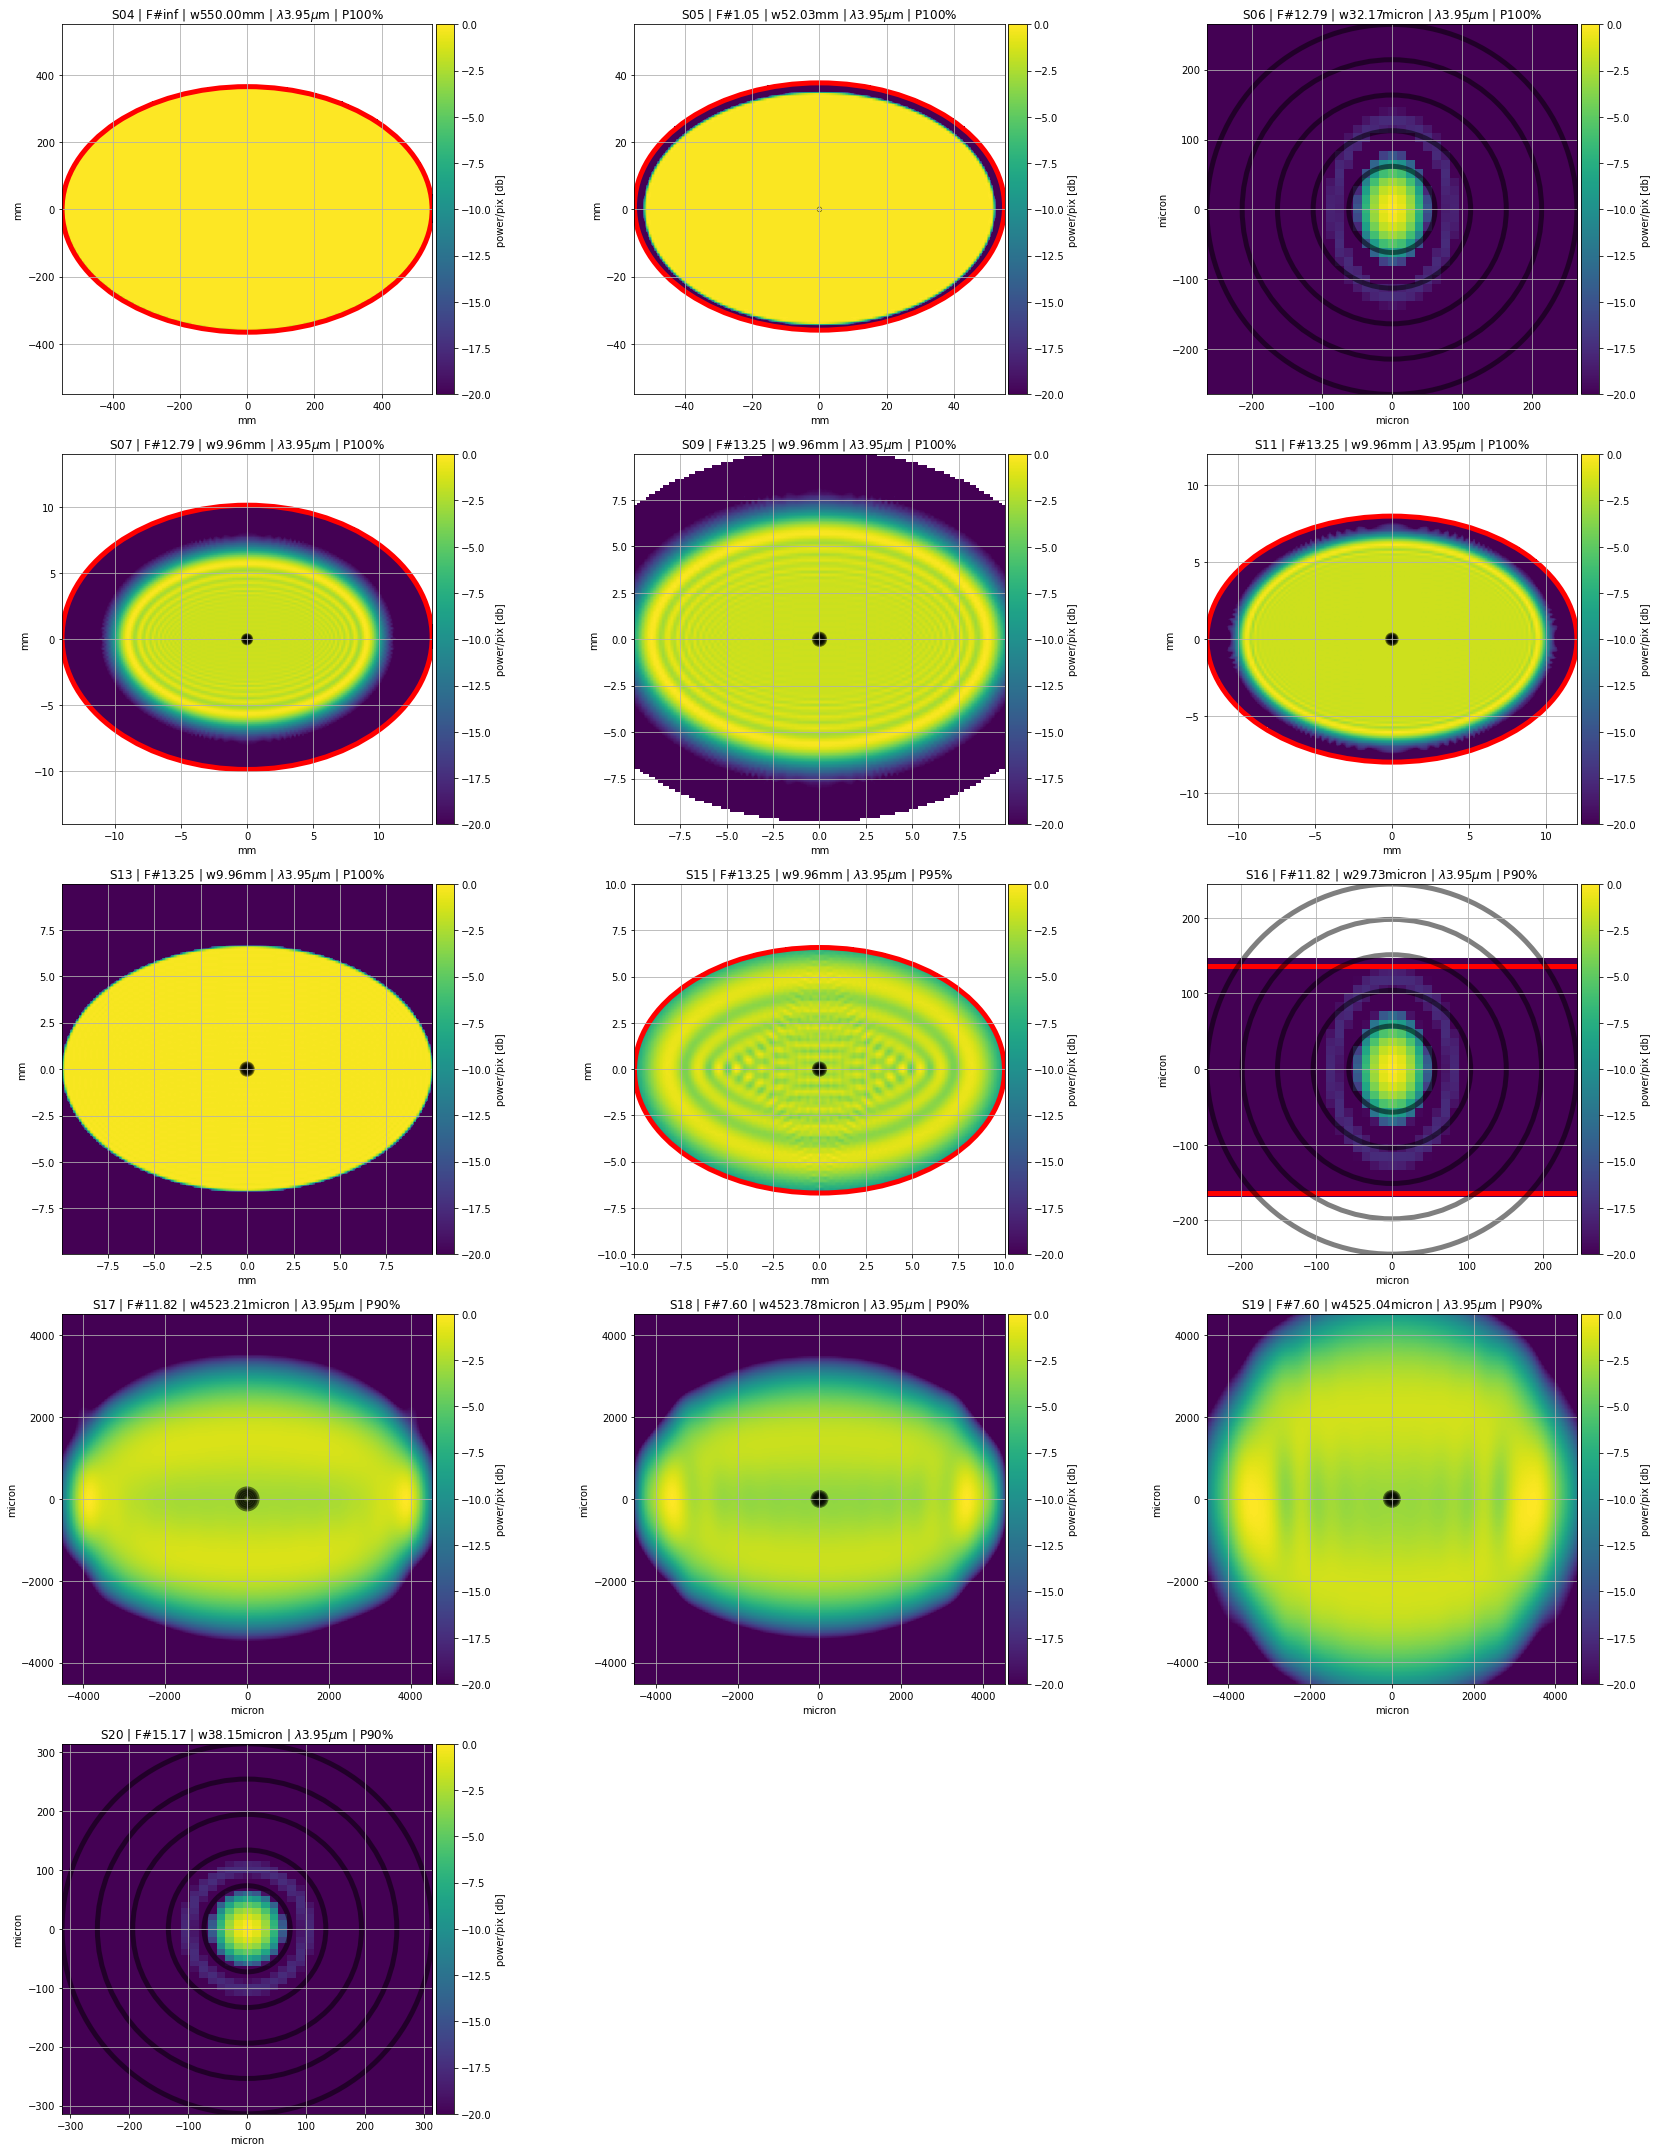

In [6]:
plots_dir = './plots'
Path(plots_dir).mkdir(parents=True, exist_ok=True)
figname = os.path.join(plots_dir, ''.join([OpticalPrescription, '_', str(1.0e-6 * wavelengths[0]), '.png']))

paos.plot_pop(retval, ima_scale='log', ncols=3, figname=None)

# Run multiple POP simulations in parallel

This section demonstrates performing multiple POP simulations using parallel threads.

In [7]:
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

# Run the POP at two different wavelengths.

start_time = time.time()
print('Start POP in parallel...')

n_jobs = 2
wavelengths = [2.0, 3.0]  #microns

ret = Parallel(n_jobs=n_jobs)(delayed(paos.run)(pup_diameter,
                                                1.0e-6 * wl,
                                                general['grid size'],
                                                general['zoom'],
                                                fields['0'], 
                                                opt_chain
                                                ) 
                                                for wl in tqdm(wavelengths))

end_time = time.time()
print('Parallel POP completed in {:6.1f}s'.format(end_time-start_time))

Start POP in parallel...


NameError: name 'general' is not defined

# Save results

This section demonstrates saving your results. 
The results are saved in .h5 format.

The saving routine are very flexible: you can either 
- save everything in your results (wfo, dx, dx, apertures...)
- or just a selection of things that you need (just the wfo, or whatever list of things)

In [ ]:
saving_dir = './data'
Path(saving_dir).mkdir(parents=True, exist_ok=True)

1) This is how to save your output if you simulated just one POP realisation. 

In [ ]:
HDF5FileName = os.path.join(saving_dir, ''.join([OpticalPrescription, '_everything.h5']))
paos.save_output(retval, HDF5FileName, overwrite=True, verbose=True)

#HDF5FileName = os.path.join(saving_dir, ''.join([OpticalPrescription, '_selection.h5']))
#save_output(retval, HDF5FileName, keys_to_keep=['wfo', 'dx'], overwrite=True, verbose=False)

2) This is how to save your output if you simulated more than one POP realisation. 

In [ ]:
# Since we just ran the POP at two different wavelengths, 
# let's use them to unequivocally tag the two simulations.

group_tags = list(map(str, wavelengths))

In [ ]:
HDF5FileName = os.path.join(saving_dir, ''.join([OpticalPrescription, '_everything_cube.h5']))
paos.save_datacube(ret, HDF5FileName, group_tags, overwrite=True, verbose=True)

#HDF5FileName = os.path.join(saving_dir, ''.join([OpticalPrescription, '_selection_cube.h5']))
#save_datacube(ret, HDF5FileName, group_tags,
#              keys_to_keep=['aperture', 'dx', 'dy'], overwrite=True, verbose=False)              